In [2]:
import pandas as pd
import os
import numpy as np
import scipy as sp
from scipy.signal import butter, lfilter, freqz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC,SVC
%matplotlib inline


# Lista de arquivos ossos original (sem desmineralização)
lista_arq_ossos=os.listdir('Dados/original/')
# Lista de arquivos ossos desmineralização 1
lista_arq_desm1=os.listdir('Dados/desm1/')
# Lista de arquivos ossos desmineralização 2
lista_arq_desm2=os.listdir('Dados/desm2/')
# Lista de arquivos ossos desmineralização 3
lista_arq_desm3=os.listdir('Dados/desm3/')

# Quantidade total de sinais
total_signal = len(lista_arq_ossos)+len(lista_arq_desm1)+len(lista_arq_desm2)+len(lista_arq_desm3)+1
# Matriz zerada para comportar todos os sinais
ossos = np.zeros((total_signal,15997))
# Matriz zerada para comportar todas as classes
classes = np.zeros((total_signal))

data_len = 15999

# Lendo os sinais de ossos sem desmineralização
i=0
# Lendo os sinais de ossos desmineralização 1
for nome2 in lista_arq_desm1:
    arq = open('Dados/desm1/'+nome2,'r')
    data = arq.readlines()
    data = [float(x) for x in data]
    data = data [2:data_len]
    data = np.array(data)
    ossos[i,:]=data
    classes[i] = 1
    i = i+1
    data=0
    arq.close()

for nome3 in lista_arq_desm2:
    arq = open('Dados/desm2/'+nome3,'r')
    data = arq.readlines()
    data = [float(x) for x in data]
    data = data [2:data_len]
    data = np.array(data)
    ossos[i,:]=data
    classes[i] = 2
    i = i+1
    data=0
    arq.close()

for nome4 in lista_arq_desm3:
    arq = open('Dados/desm3/'+nome4,'r')
    data = arq.readlines()
    data = [float(x) for x in data]
    data = data [2:data_len]
    data = np.array(data)
    ossos[i,:]=data
    classes[i] = 3
    i = i+1
    data=0
    arq.close()
ossos = ossos[: i,:]
classes = classes[:i]


ossos

array([[-1.500000e-04, -1.500000e-04, -1.500000e-04, ..., -2.706030e-04,
        -2.706030e-04, -2.706030e-04],
       [-1.000000e-04, -1.000000e-04, -1.000000e-04, ..., -4.216080e-04,
        -4.216080e-04, -4.216080e-04],
       [-1.000000e-04, -1.000000e-04, -1.000000e-04, ..., -7.432160e-04,
        -7.432160e-04, -7.432160e-04],
       ...,
       [-2.766330e-04, -2.766330e-04, -2.766330e-04, ..., -1.362060e-03,
        -1.482663e-03, -1.482663e-03],
       [-5.402000e-05, -5.402000e-05, -5.402000e-05, ..., -1.340452e-03,
        -1.340452e-03, -1.340452e-03],
       [-3.851760e-04, -3.851760e-04, -3.851760e-04, ..., -3.851760e-04,
        -3.851760e-04, -3.851760e-04]])

In [27]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 8000    # sample rate, Hz
cutoff =30 # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Demonstrate the use of the filter.
# First make some data to be filtered.
n = 15997 # total number of samples
T = int(n/fs)        # seconds
t = np.linspace(0, T, n, endpoint=False)

ossos_filtered = np.zeros((total_signal,15997))


def filterData(data,cutoff,fs,order):
    # Filter the data, and plot both the original and filtered signals.
    y = butter_lowpass_filter(data, cutoff, fs, order)
    return y


for i in range(len(ossos)):
    # "Noisy" data. 
    data = ossos[i,:]
    y = filterData(data,cutoff,fs,order)
    ossos_filtered[i,:] = y


ossos_df = pd.DataFrame(ossos)
classes_df= pd.DataFrame(classes)
classes_df['Desm'] = classes_df[0]
classes_df = classes_df.drop(0,axis=1)
result = pd.concat([ossos_df, classes_df], axis=1, sort=False)
result

,0,1,2,3,4,5,6,7,8,9,...,15988,15989,15990,15991,15992,15993,15994,15995,15996,Desm
0,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,-0.000150,...,-0.000391,-0.000391,-0.000391,-0.000271,-0.000271,-0.000271,-0.000271,-0.000271,-0.000271,1.0
1,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,...,-0.000422,-0.000422,-0.000422,-0.000422,-0.000422,-0.000422,-0.000422,-0.000422,-0.000422,1.0
2,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,-0.000100,...,-0.000582,-0.000743,-0.000743,-0.000743,-0.000743,-0.000743,-0.000743,-0.000743,-0.000743,1.0
3,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,...,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,1.0
4,-0.000039,-0.000039,-0.000039,-0.000039,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,-0.000200,...,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000122,0.000282,0.000282,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,-0.000307,-0.000307,-0.000307,-0.000307,-0.000307,-0.000187,-0.000187,-0.000066,-0.000066,-0.000066,...,-0.001152,-0.001152,-0.001152,-0.001031,-0.001031,-0.001031,-0.001031,-0.001031,-0.001152,3.0
1192,-0.000127,-0.000127,-0.000127,-0.000127,-0.000127,-0.000127,-0.000127,-0.000127,-0.000127,-0.000127,...,-0.000328,-0.000328,-0.000328,-0.000328,-0.000328,-0.000328,-0.000328,-0.000529,-0.000328,3.0
1193,-0.000277,-0.000277,-0.000277,-0.000277,-0.000277,-0.000277,-0.000277,-0.000277,-0.000156,-0.000277,...,-0.001483,-0.001483,-0.001483,-0.001483,-0.001362,-0.001362,-0.001362,-0.001483,-0.001483,3.0
1194,-0.000054,-0.000054,-0.000054,-0.000054,-0.000215,-0.000215,-0.000215,-0.000215,-0.000215,-0.000215,...,-0.001340,-0.001340,-0.001340,-0.001340,-0.001340,-0.001340,-0.001340,-0.001340,-0.001340,3.0


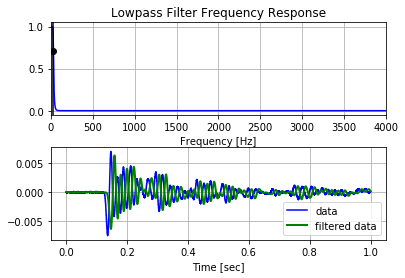

In [28]:
def plotFiltered(t,y,data,a,b,fs,cutoff):
    # Plot the frequency response.
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()



    plt.subplot(2, 1, 2)
    plt.plot(t, data, 'b-', label='data')
    plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()
idx = 10 #escolha um valor
data = ossos[idx,:]
y = ossos_filtered[idx,:]
plotFiltered(t,y,data,a,b,fs,cutoff)

In [67]:
clf = SVC(gamma='scale', decision_function_shape='ovo')
X = result.drop(['Desm'],axis=1)
y = result['Desm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf.fit(X_train,y_train) 
pred_clf = clf.predict(X_test)
print(classification_report(y_test, pred_clf))
cm_clf= confusion_matrix(y_test, pred_clf)
print(cm_clf)

              precision    recall  f1-score   support

         1.0       0.62      0.63      0.63        79
         2.0       0.69      0.47      0.55       159
         3.0       0.64      0.90      0.75       121

    accuracy                           0.65       359
   macro avg       0.65      0.67      0.64       359
weighted avg       0.66      0.65      0.64       359

[[ 50  25   4]
 [ 27  74  58]
 [  3   9 109]]
